In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [114]:
%ls

data_I.ipynb         eluniversal_21_02_17.csv  scraper/
elpais_21_02_17.csv  newspaper_receipe.py


In [3]:
pd.options.display.max_rows = 10

In [68]:
df_elpais = pd.read_csv('scraper/elpais_21_02_17_articles.csv',encoding='utf-8')
df_elpais.head(2)

,body,title,url
0,"{'Detrás de cada una de las contribuciones, ha...",¿Quién es Alem2112?,https://www.pagina12.com.ar/324327-quien-es-al...
1,{'El gobierno autónomo palestino envió este mi...,Israel permitió finalmente el ingreso a Gaza d...,https://www.pagina12.com.ar/324312-israel-perm...


In [65]:
df_eluniversal = pd.read_csv('scraper/eluniversal_21_02_15_articles.csv',encoding='utf-8')
df_eluniversal.sample(2)

,body,title,url
19,Bogotá.- Con el cierre de cafés y oficinas en ...,"El café, un sobreviviente de la pandemia",http://www.eluniversal.com/economia/90566/el-c...
27,Prensa Polisotillo.- Este miércoles tres miemb...,Polisotillo capturó a miembros de grupo delict...,http://www.eluniversal.com/sucesos/90337/polis...


In [13]:
mask = df_eluniversal['title'].isna()
mask

0     False
1     False
2     False
3     False
4     False
      ...  
31    False
32    False
33    False
34    False
35    False
Name: title, Length: 36, dtype: bool

In [6]:
df_eluniversal.loc[:,'title']

0     Una joven de EEUU se peina con pegamento y lue...
1     Falleció Leopoldo Luque, figura de Argentina e...
2     Realizaron Gran toma Cultural y Deportiva en e...
3                  Yolanda Moreno, pasión por Venezuela
4                    Venezuela es territorio retornable
                            ...                        
31         Los duques de Sussex esperan su segundo hijo
32    El Partido Republicano entra en combustión con...
33    El Athletic de Bilbao se instala en la zona tr...
34                      Lara recibirá vacunas Sputnik V
35    Asesinan a funcionario de la Dgcim en el estad...
Name: title, Length: 36, dtype: object

In [7]:
print(df_eluniversal[['url']].sample(5))

                                                  url
27  http://www.eluniversal.com/sucesos/90337/polis...
28  http://www.eluniversal.com/el-universal/90385/...
13  http://www.eluniversal.com/entretenimiento/905...
12  http://www.eluniversal.com/economia/90569/rest...
30  http://www.eluniversal.com/sociales/90463/en-b...


In [8]:
(df_eluniversal['url'].str
                      .extract(r'(?P<url_title>[^/]+)$') #EXtraigo el titulo de la url
                      .applymap(lambda x : x.split('-')) #Divido por los - que los separa
                      .applymap(lambda x : ' '.join(x))) #Uno con espacios 

,url_title
0,una joven de eeuu se peina con pegamento y lue...
1,fallecio leopoldo luque figura de argentina en...
2,realizaron gran toma cultural y deportiva en e...
3,yolanda moreno pasion por venezuela
4,venezuela es territorio retornable
...,...
31,los duques de sussex esperan su segundo hijo
32,el partido republicano entra en combustion con...
33,el athletic de bilbao se instala en la zona tr...
34,lara recibira vacunas sputnik v


In [16]:
df_eluniversal.loc[mask,'title']

Series([], Name: title, dtype: object)

# Wrangling

### Creo un hash para el índice 

In [29]:
import hashlib
uid = (df_eluniversal['url'].apply(lambda row : hashlib.md5(bytes(row.encode())))
                      .apply(lambda hash_object: hash_object.hexdigest() ) #Cambio el objeto hash a hexadecimal 
)
df_eluniversal['uid'] = uid
df_eluniversal.set_index('uid',inplace=True)

In [31]:
df_eluniversal.sample(2)

,body,title,url
uid,,,
2464e5b9ed947dcb85736e5d759cc143,Lara.- A Lara ya llegaron las cavas que almace...,Lara recibirá vacunas Sputnik V,http://www.eluniversal.com/venezuela/90589/lar...
2c47ddcadfedd2d5d4c0fe15e05111cf,"Coca-Cola 1,25 litros, que se ofrece en botell...",Venezuela es territorio retornable,http://www.eluniversal.com/economia/90229/vene...


### Remplazar carácteres indeciados del body

In [40]:
import re
stripped_body = df_eluniversal['body'].apply(lambda row : re.sub(r'[{|}|\n]+','',row))

In [58]:
stripped_body2 = (df_eluniversal['body']
    .apply(lambda row : list(row))
    .apply(lambda letter : list(map(lambda letter: letter.replace('\n','').replace('{','').replace('}','') , letter)))
    .apply(lambda letter : ''.join(letter))
 
)
stripped_body2

uid
c7fdc36343e74ea37cb2e9de631ea661    Una joven estadounidense que se peinó con pega...
8ca7525c582d7b2cf339cee04dd6ad93    Buenos Aires.- Leopoldo Jacinto Luque, autor d...
c89d2c43a9d3c2f53cd0fd3ffd9f0c05    A propósito de los Carnavales Caracas Caribe 2...
4ae1b2a86d4cb32eaf3b74236abc33cb    Yolanda Moreno es la nueva embajadora #MarcaVe...
2c47ddcadfedd2d5d4c0fe15e05111cf    Coca-Cola 1,25 litros, que se ofrece en botell...
                                                          ...                        
d8f4ef4ab60e9d17b4a775bea793524d    Los Sussex confirmaron que esperan su segundo ...
8a99f53536e6f815c39023f3254bf510    El segundo juicio por impeachment a Donald Tru...
f9ce1f89f61346fd9b589d37c37aa39c    Madrid.- El Athletic de Bilbao arrasó en su vi...
2464e5b9ed947dcb85736e5d759cc143    Lara.- A Lara ya llegaron las cavas que almace...
ef82fafe03773a0d713855f8aeddfc32    Un hombre identificado como Freddy Richardy En...
Name: body, Length: 36, dtype: object

### Tokenizar las palabras
Para saber cuantas palabras significantes hay 

In [71]:
import nltk
from nltk.corpus import stopwords

In [72]:
#nltk.download('punkt')     #Solo se tiene que hacer una vez 
#nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/cesar/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/cesar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [105]:
stop_words = set(stopwords.words('spanish'))  #Creo un set con las stop words que son paralbras como la, el. Que no suman valor 

def token_column(df,name_column):
    return (df
            .dropna()
            .apply(lambda row : nltk.word_tokenize(row[name_column]),axis = 1) #Creo los token, que son las palabras
            .apply(lambda tokens : list(filter(lambda word: word.isalpha(),tokens)))# Filtro todas las a
            .apply(lambda tokens : list(map(lambda word:word.lower(), tokens))) #Coloco todas en minúscula para que se puedan comparar con la lista de stops words 
            .apply(lambda tokens : list(filter(lambda word: word not in stop_words , tokens)))#Filtro palabras quenno esten en las stop words
            .apply(lambda tokens : len(tokens))
           )


In [185]:
df_eluniversal[['title','num_of_tokens']].head()

,title,num_of_tokens
0,Una joven de EEUU se peina con pegamento y lue...,8
1,"Falleció Leopoldo Luque, figura de Argentina e...",7
2,Realizaron Gran toma Cultural y Deportiva en e...,8
3,"Yolanda Moreno, pasión por Venezuela",4
4,Venezuela es territorio retornable,3


# Valores repetidos
Eliminar los valores repetidos

In [207]:
df_eluniversal['title'].value_counts()

Venezuela es territorio retornable                                                                                 1
Pueblo protagonista                                                                                                1
Un concurso para celebrar el mes más romántico del año                                                             1
El Partido Republicano entra en combustión con el voto del ‘impeachment’ a Trump                                   1
Gladys Chacón: "Infraestructura educativa en Venezuela no está en condiciones para retomar clases presenciales"    1
                                                                                                                  ..
Los duques de Sussex esperan su segundo hijo                                                                       1
Una joven de EEUU se peina con pegamento y luego pide ayuda en internet                                            1
Yolanda Moreno, pasión por Venezuela                            

In [205]:
len(df_eluniversal)

82

In [201]:
df_eluniversal.drop_duplicates(subset=['title'],keep='first',inplace=True) #Elimno los posible titulos duplicados

# Cargo el scrip con todo los procedimientos incluidos

In [223]:
%ls

data_I.ipynb         eluniversal_21_02_17.csv  scraper/
elpais_21_02_17.csv  newspaper_receipe.py


In [222]:
%run newspaper_receipe.py scraper/elpais_21_02_17_articles.csv title

INFO:news paper wraggling__main__:Starting to cleaning the data
INFO:news paper wraggling__main__:Start reading the data base
INFO:news paper wraggling__main__:name detected, starting to extract the data
INFO:news paper wraggling__main__:the site id is elpais
INFO:news paper wraggling__main__:Starting to crate the site id (elpais) column
INFO:news paper wraggling__main__:Starting to create the url parse column
INFO:news paper wraggling__main__:Filling missing titles
INFO:news paper wraggling__main__:Creating index hash
INFO:news paper wraggling__main__:Replacing of countless characters
INFO:news paper wraggling__main__:Saving the new file
INFO:news paper wraggling__main__:Starting to cleaning the data
INFO:news paper wraggling__main__:Start reading the data base
INFO:news paper wraggling__main__:name detected, starting to extract the data
INFO:news paper wraggling__main__:the site id is elpais
INFO:news paper wraggling__main__:Starting to crate the site id (elpais) column
INFO:news pap

In [256]:
%run newspaper_receipe.py eluniversal_21_02_17.csv 

INFO:news paper wraggling__main__:Starting to cleaning the data
INFO:news paper wraggling__main__:Start reading the data base
INFO:news paper wraggling__main__:name detected, starting to extract the data
INFO:news paper wraggling__main__:the site id is eluniversal
INFO:news paper wraggling__main__:Starting to crate the site id (eluniversal) column
INFO:news paper wraggling__main__:Starting to create the url parse column
INFO:news paper wraggling__main__:Filling missing titles
INFO:news paper wraggling__main__:Creating index hash
INFO:news paper wraggling__main__:Replacing of countless characters
INFO:news paper wraggling__main__:Saving the new file


In [257]:
clean_eluniversal = pd.read_csv('eluniversal_21_02_17.csv')

In [258]:
clean_elpais = pd.read_csv('elpais_21_02_17.csv')

# Visualization

In [260]:
clean_elpais.sample(2)

,uid,body,title,url,elpais,host,num_title,num_body,uid_site
68,6465fbb6efd55c7ad76178e59fd85f14,"'La monogamia, la pareja cerrada, la figura de...",Se edita en Argentina el libro de Brigitte Vas...,https://www.pagina12.com.ar/322713-se-edita-en...,elpais,www.pagina12.com.ar,6,1488,elpais
46,d30eaca49079c9e204edf401fc7551b3,'El presidente Alberto Fernández recibirá este...,Alberto Fernández recibe a la madre de la jove...,https://www.pagina12.com.ar/324279-alberto-fer...,elpais,www.pagina12.com.ar,8,78,elpais


In [229]:
clean_eluniversal.describe()

,num_title,num_body
count,36.000000,36.000000
mean,5.583333,189.944444
std,2.322253,146.181286
min,2.000000,49.000000
25%,4.000000,87.500000
50%,5.000000,147.500000
75%,8.000000,220.750000
max,10.000000,682.000000


<AxesSubplot:>

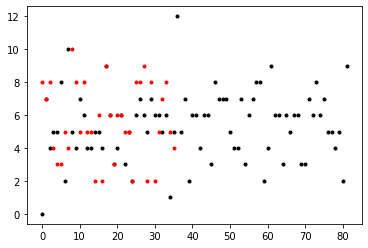

In [243]:
clean_elpais.loc[:,'num_title'].plot(style='k.')
clean_eluniversal.loc[:,'num_title'].plot(style='r.')

In [248]:
clean_elpais.loc[30:,:]

,uid,body,title,url,elpais,host,num_title,num_body
30,d8bf25bea86ee2bc46d84efb42614f84,'El futuro llegó hace rato pero a veces no es ...,"César Hazaki: ""La tecnofilia empieza a mostrar...",https://www.pagina12.com.ar/324137-cesar-hazak...,elpais,www.pagina12.com.ar,6,997
31,4043ef76bffe64b348b7a14a16fc2e3f,"""Johnny Pacheco, una de las figuras fundamenta...","Johnny Pacheco, figura de la salsa, murió a lo...",https://www.pagina12.com.ar/324139-johnny-pach...,elpais,www.pagina12.com.ar,6,562
32,61cd123ad425884f58bdaf0587d7f572,"'La fiscal general de Nueva York, Letitia Jame...",Demandan a Amazon por no proteger a sus emplea...,https://www.pagina12.com.ar/324331-demandan-a-...,elpais,www.pagina12.com.ar,5,289
33,841a5d109302f2844a3f27cfb67e0070,"""Joan Margarit, premio Cervantes en 2019, muri...",El poeta catalán Joan Margarit murió a los 82 ...,https://www.pagina12.com.ar/324182-el-poeta-ca...,elpais,www.pagina12.com.ar,6,668
34,378249631fa72d88d0b0aa51d25d3035,'EL CUENTO POR SU AUTORCorrían los primeros añ...,El gigante,https://www.pagina12.com.ar/323511-el-gigante,elpais,www.pagina12.com.ar,1,1037
...,...,...,...,...,...,...,...,...
77,d101e39c3ea6f9aeb2e2e6bcb0759118,"'Dana Hernández, la dirigenta más joven en la ...","""Los clubes son el último bastión que tiene el...",https://www.pagina12.com.ar/324121-los-clubes-...,elpais,www.pagina12.com.ar,5,439
78,571b6346e4236e8dd43995e9d543297f,"'Cualquiera que, llevado por la nostalgia de t...",DisneyPlus: Yendo de la selva al clóset,https://www.pagina12.com.ar/322732-disney-plus...,elpais,www.pagina12.com.ar,4,477
79,20f82b64033100d995bbda2bf29664e2,"'Con la nueva modalidad de viajes, que atrajo ...",Gran movimiento turístico en Salta para Carnaval,https://www.pagina12.com.ar/324272-gran-movimi...,elpais,www.pagina12.com.ar,5,386
80,0f1cb4e9816742b817bd449f11992e02,'',Nico Ketama,https://www.pagina12.com.ar/324092-nico-ketama,elpais,www.pagina12.com.ar,2,0


In [262]:
concat_df = pd.concat([clean_elpais,clean_eluniversal],join='outer')

uid_site
elpais         AxesSubplot(0.125,0.125;0.775x0.755)
eluniversal    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

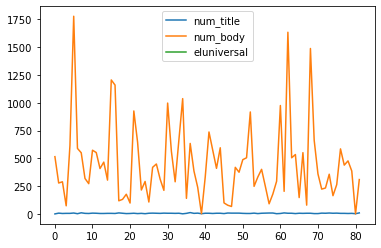

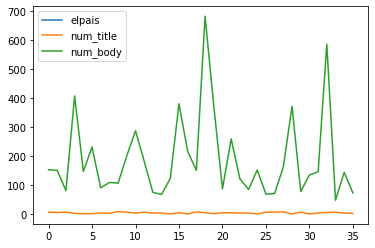

In [264]:
concat_df.groupby('uid_site').plot()

uid_site
elpais         [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
eluniversal    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

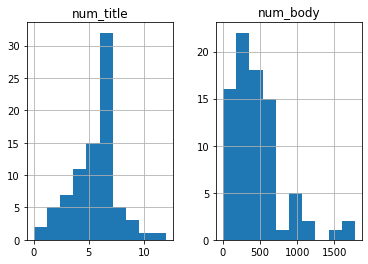

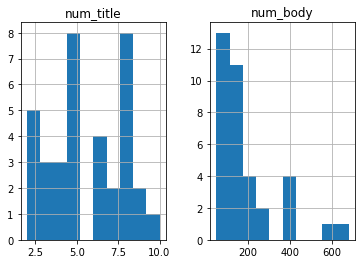

In [268]:
concat_df.groupby('uid_site').hist()

In [272]:
concat_df.groupby('uid_site')[['num_title','num_body']].agg([max,min,np.median,np.mean])

num_title                      num_body                       
                  max min median      mean      max min median        mean
uid_site                                                                  
elpais             12   0      6  5.414634     1778   0  380.5  450.780488
eluniversal        10   2      5  5.583333      682  49  147.5  189.944444

## test

In [287]:
df_t1 = pd.read_csv('elpais_21_02_18.csv')

In [288]:
list(df_t1)

['uid', 'body', 'title', 'url', 'uid_site', 'host', 'num_title', 'num_body']

In [1]:
%cd transform/

/home/cesar/Documents/practica_cursos/code/python/ingenieria_de_datos/transform


In [5]:
import pandas as pd

In [7]:
pd.read_csv('elpais_.csv')

,body,title,url
0,{'El pequeño detective\xa0 \xa0 \xa0 \xa0 \xa0...,"""El pequeño detective"": en busca del paraíso p...",https://www.pagina12.com.ar/324372-el-pequeno-...
1,{'\n \n\n\n\nLos recordatorios se reciben en\x...,Carlos Horacio Benigno Vivas,https://www.pagina12.com.ar/324354-carlos-hora...
2,{'Los organismos de derechos humanos resolvier...,Los Organismos de Derechos Humanos no marchará...,https://www.pagina12.com.ar/324546-los-organis...
3,{'Primero. Que no hay nada de cierto en lo que...,¿Qué expone el lawfare?,https://www.pagina12.com.ar/324436-que-expone-...
4,"{'El lugar es Botoșani, en Rumania. El año: 19...","Radu Jude: ""No me interesa hacer películas que...",https://www.pagina12.com.ar/324381-radu-jude-n...
...,...,...,...
80,"{'“Nos vamos a cargar el fútbol”, lamentaba en...",Explotados y ninguneadas,https://www.pagina12.com.ar/324582-explotados-...
81,"{'El indio guerrero Amoim Aruká, último hombre...","Murió por coronavirus Amoim Aruká, el último s...",https://www.pagina12.com.ar/324565-murio-por-c...
82,{'La última estafa que circula a través de Wha...,La nueva estafa para robar cuentas de WhatsApp,https://www.pagina12.com.ar/324392-la-nueva-es...
83,"{'La ministra de las Mujeres, Políticas de Gén...","Estela Díaz reclamó a la Justicia una ""interve...",https://www.pagina12.com.ar/324555-estela-diaz...


In [14]:
%run newspaper_receipe.py elpais_.csv

INFO:news paper wraggling__main__:Starting to cleaning the data
INFO:news paper wraggling__main__:Start reading the data base
INFO:news paper wraggling__main__:name detected, starting to extract the data
INFO:news paper wraggling__main__:the site id is elpais
INFO:news paper wraggling__main__:Starting to crate the site id (elpais) column
INFO:news paper wraggling__main__:Starting to create the url parse column
INFO:news paper wraggling__main__:Filling missing titles
INFO:news paper wraggling__main__:Creating index hash
INFO:news paper wraggling__main__:Replacing of countless characters
INFO:news paper wraggling__main__:Start to craeting the tokens
INFO:news paper wraggling__main__:Start to craeting the tokens
INFO:news paper wraggling__main__:Saving the new file


In [10]:
%ls

elpais_21_02_18.csv  elpais_.csv  eluniversal_.csv  newspaper_receipe.py


In [15]:
pd.read_csv('elpais_21_02_18.csv')

,uid,body,title,url,uid_site,host,num_title,num_body
0,a3f0f73918715d931068fac47edaa4f5,'El pequeño detective 8 putosThe Kid Dete...,"""El pequeño detective"": en busca del paraíso p...",https://www.pagina12.com.ar/324372-el-pequeno-...,elpais,www.pagina12.com.ar,5,457
1,3dfb653292131360fcbb363ee1f0c5c0,' Los recordtorios se recibe e[emilprotected]',Carlos Horacio Benigno Vivas,https://www.pagina12.com.ar/324354-carlos-hora...,elpais,www.pagina12.com.ar,4,3
2,08831d4eada0c4f5402b8b4ed25c7be8,'Los orgismos de derechos humos resolviero que...,Los Organismos de Derechos Humanos no marchará...,https://www.pagina12.com.ar/324546-los-organis...,elpais,www.pagina12.com.ar,6,304
3,f9e89f854d9b9dab8d7ab6955ae1aad7,'Primero. Que o hy d de cierto e lo que os ese...,¿Qué expone el lawfare?,https://www.pagina12.com.ar/324436-que-expone-...,elpais,www.pagina12.com.ar,2,335
4,defe4b5ddd911016223512afbde7e65e,"'El lugr es Botoși, e Rumi. El ño: 1981. L fig...","Radu Jude: ""No me interesa hacer películas que...",https://www.pagina12.com.ar/324381-radu-jude-n...,elpais,www.pagina12.com.ar,10,1150
...,...,...,...,...,...,...,...,...
80,0ed66dac609a3c1a4904aad2a164e493,"'“Nos vmos crgr el fútbol”, lmetb e oviembre ...",Explotados y ninguneadas,https://www.pagina12.com.ar/324582-explotados-...,elpais,www.pagina12.com.ar,2,1110
81,921fb82b26f2a92936e1f39914e1295a,"'El idio guerrero Amoim Aruká, último hombre s...","Murió por coronavirus Amoim Aruká, el último s...",https://www.pagina12.com.ar/324565-murio-por-c...,elpais,www.pagina12.com.ar,10,178
82,800a60303284078743b30eb15d60268b,'L últim estf que circul trvés de WhtsApp es ...,La nueva estafa para robar cuentas de WhatsApp,https://www.pagina12.com.ar/324392-la-nueva-es...,elpais,www.pagina12.com.ar,5,227
83,37ed4ce67b4b3d39abee141279e6c1ae,"'L miistr de ls Mujeres, Polítics de Géero y D...","Estela Díaz reclamó a la Justicia una ""interve...",https://www.pagina12.com.ar/324555-estela-diaz...,elpais,www.pagina12.com.ar,9,139
